<a href="https://colab.research.google.com/github/youxeff/Google-Search-Replica/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3: Finding Local Max in PPG Signal
<font size="6"> Laboratory 2  </font> <br>
<font size="3"> Last updated September 9, 2023</font>

## <span style="color:orange;"> 00. Content </span>

<font size="5"> Mathematics </font>
- Additive error model; bias in error
- Noise removal by averaging
- Finding local maxima as "peaks"
- Choosing a sampling rate based on distance between local maxima
- Local maxima defined as location between function increase and decrease
- Thresholding
- Computing beats per minutes (BMP) from peaktimes
    
<font size="5"> Programming Skills </font>
- Best practice: use separate data file and analysis file
- Use/modify given Python data acquisition code
- Save data in text file
- Load data from text file
- Look at loaded data
- Plotting data
- Changing x-axis in a plot
- Array building
- Zooming into plot
- Use of averaging code
- Use of local maxima identify code
- NaN
- Use of thresholding code
- Write code to compute beats per minutes (BMP) from peaktimes

<font size="5"> Embedded Systems </font>
- Thonny and Micropython
- Installing Micropython on Pico

## <span style="color:orange;"> 0. Required Hardware </span>

- Microcontroller: Raspberry Pi Pico
- Pulse sensor
- Ceramic Capacitor
- Breadboard
- USB connector

<h3 style="background-color:lightblue"> Write your name and email below: </h3>

First Name: Youssef, Last Name: Abdelkader, email: yabdelk@purdue.edu

## <span style="color:orange;"> 1. Introduction to error analysis </span>


> In order to improve, we must first recognize that we are not perfect.

Today we will begin using numbers collected from the real world. Every number you measure is subject to several kinds of error from different sources. This is the first and most important lesson of error analysis: *every measurement has error. The goal is not to eliminate error, but rather to reduce it to an acceptable level.* As we progress through the semester, we will develop strong tools for analyzing and reducing error in our measurements, based off of differential calculus and Taylor series. Before we can do that, we need to establish some common language and techniques for describing errors.

### Types of error

An error is anything which can make it so that the number you get is different from the actual value of the quantity you are measuring. Here are a few sources of error you are likely to encounter:

 - measurement error. This is what most people think of when they hear about an error in measurement. This includes everything which could go wrong with your measurement instrument. Perhaps the marks on a ruler are not placed exactly evenly, or it isn't being held straight. Perhaps the paralax on a measurement dial leads to misalignment between the needle and the dial. Perhaps your tool is low on batteries and is malfunctioning.
 - roundoff error. Also called truncation error. This is where a number is off a little bit because it was rounded. For example, Alden's favorite pocket calculator the TI-30Xa only keeps 14 digits of $\pi$. If you needed $\pi$ to any further precision, you would have to use a different calculator. Usually the cure for this source of error is fairly simple -- just keep more digits! However, this is not always practical: maybe you are using numbers someone else has rounded and cannot access the original data, or maybe keeping enough digits for your task would be too cumbersome. We will see some examples in a few weeks, when we study numerical differentiation, where roundoff error becomes really important.
 - modeling error. Every computation is based on a model, and every model is inaccurate. For example, suppose you want to measure the volume of the earth. You could perform astronomical measurements to figure out the radius of the earth, and use the volume formula for a sphere, $\frac{4}{3} \pi r^3$ to figure out the volume. The formula is perfect, without error, provided you are talking about a true sphere. As anyone knows, however, the earth is not a perfect sphere (it has mountains, for one thing). Therefore, there is some error associated with modeling the earth as a perfect sphere, which will affect your final volume computation.
 - definitional error. This is perhaps the most frequently overlooked source of error, and its definition gets a bit philosophical. Usually we can't get to a level where it is important in the physical sciences, though it is frequently important in the social sciences. As an example, consider the old unit of length, the barleycorn. This is still used today to measure shoe sizes. Its definition could not be simpler: it's the length of a grain of barley, roughly 1/3 of an inch or 8.5 millimeters. There is a problem here though: barley has some natural variablility of size, from 6.4 millimeters at the smallest to 13 millimeters at the longest [(see this study if you want to know more about barley)](https://www.agriculturejournals.cz/publicFiles/10118.pdf). So, depending on which type of barley you are using, your shoe could wind up being a bad fit. It's not a matter of the barley being a bad tool for measuring length in barleycorns: you can always tell exactly how long something is in barleycorns by lining up a row of barley, and you will be correct by definition. It's a problem with the definition of the length unit -- the definition has some error built in. This usually doesn't affect us when making distance measurements, since we have better definitions now for length, based off the speed of light and our definition of time. However, for very sensitive measurements, it is still sometimes an issue. Furthermore, for more abstractly defined quantities (such as intelligence, or anxiety, or pain) the definition still has a significant amount of error built in which can sometimes be the biggest source of error in a computation.

This is a relatively simple taxonomy of errors, but it encompasses most of the important sources of error you are likely to encounter. If you can think of a source of error which does not fit this taxonomy, we would like to hear about it (email mboutin at purdue dot you know what). As we will see, you could waste a lot of effort reducing the error from one source only to find that a different source is introducing way more error, making your efforts fruitless. Therefore, it is important to be aware of how each source of error could creep in.



### <span style="color:red;"> Exercise 1 </span>

For each source of error listed, classify it according to the taxonomy above. Explain why it fits into the category you chose.

1. You have a thermometer in your garden which you use to tell the temperature in the morning. The sun shines directly on the thermometer, making it read a temperature higher than the air temperature.

2. You use a tire pressure gauge to figure out the pressure in your car tires. It only has a marking every 2 PSI, so you do your best to estimate the value to the nearest PSI.

3. You use a GPS system to track how long your commute is, but it only takes into account longitude and latitude, not elevation.

<h3 style="background-color:lightblue"> Write Answers for Exercise 1 Below </h3>

1. Measurment Error: The thermometer is affected by direct sunlight rather than the actual temperature.
2. Roundoff error: The limited resolution of the gauge forces you to estimate the pressure to the nearest PSI.
3. Modeling Error: The GPS model assumes a flat 2D plane

### Two ways errors behave

We usually represent error with a variable either as $e$ (short for error), or in Greek with the lower case letter epsilon which makes the same sound, written as either $\epsilon$ or $\varepsilon$. This lets us represent how any measured quantity $x$ is related to its "true value" $t$:
\begin{align*}
x = t + \varepsilon.
\end{align*}
This is sometimes called *the most famous equation of measurement theory*.

#### Random error

Our goal is usually to make the total error small. For some types of error, $\varepsilon$ is on average zero; the error is just as often positive as it is negative. A consequence of this is that if you took lots and lots of measurements (say $x_1=t+\varepsilon_1$, $x_2=t+\varepsilon_2$, $\dots$, $x_k=t+\varepsilon_k$) then you could take the average
\begin{align*}
\frac{x_1+x_2+\dots+x_k}{k} = t + \frac{\varepsilon_1+\varepsilon_2+\dots+\varepsilon_k}{k}
\end{align*}
and the term $\frac{\varepsilon_1+\varepsilon_2+\dots+\varepsilon_k}{k}$ would tend to be much smaller than each $\varepsilon_i$ on its own, since the positive and negative terms would mostly cancel each other out. This is really useful, since it gives us a way of reducing the total error, getting a better estimate of the value $t$. If this is the case, we say that the error in $x$ is *random*. This technique for reducing random error [was invented in the 1700s.](https://www.math.purdue.edu/~bradfoa/misc_files/arithmetic_mean.pdf) (See  for example page 121 of "Studies in the History of Statistics and Probability," by M.G. Kendall, 1960.)

#### Systematic error

Unfortunately, we are often not so lucky as to only have random error. Very often there is some bias in our measurement which causes it to be usually positive or usually negative, so it does not help much to use the repeated measurement procedure described above. In this case we say there is a *systematic* error.

For example, let's say you decide to save some computer cycles in a computation by truncating your numbers -- instead of rounding (which could take some additional time, depending on how your computer is set up) you decide to just drop the least significant digits. The effect of this is that you will always be making the number smaller. It's just like if you always decided to round down. In the terms outlined above, $\varepsilon$ is always negative in this case.

As another example, suppose you are weighing precise amounts of material in a chemistry lab on a sensitive scale, but you don't have a cover over the scale and there is a slight downdraft at the work bench. You are leaning over the scale when you hit the tare button, shielding the scale from the air current. The air would push down on the scale a bit during the weighting, causing your estimated weight $x$ to usually be a little bit bigger than $t$. It would still vary randomly, but since $\varepsilon$ would usually be positive we would say that this is a systematic error in the positive direction.

### <span style="color:red;"> Exercise 2 </span>

For each source of error described, classify it as a random or a systematic error. If it is a systematic error, say whether it is in the positive or negative direction. Justify your answers with a brief sentence or two.

1. You are measuring your height against a wall by placing a book on your head and seeing where the book touches the wall, measuring the length along the wall from the floor with a tape measure. Unfortunately, you cannot guarantee that the book is completely level.

2. You make sure the book from problem 1 is level by placing one edge vertically along the wall, measuring from there to the base of the wall. Unfortunately, the wall is very slightly sloped toward you.

3. You have a thermometer in your garden which you use to tell the temperature in the morning. The sun shines directly on the thermometer.

4. You use a tire pressure gauge to figure out the pressure in your car tires. It only has a marking every 2 PSI, so you do your best to estimate the value to the nearest PSI.

5. You use a GPS system to track how long your commute is, but it only takes into account longitude and lattitude, not elevation.

<h3 style="background-color:lightblue"> Write Answers for Exercise 2 Below </h3>

1. Random Error
2. Systamtic Error : Both Postive and Negative
3. Systamatic Error: Posititve
4. Random Error
5. Systamtic Error : negative

## <span style="color:orange;"> 2. Data Acquisition </span>

You will collect data today using the [MAX30102 heart rate sensor module](https://www.analog.com/media/en/technical-documentation/data-sheets/max30102.pdf), which shines an invisible infrared light on your skin and measures how much comes back to get a number which is proportional to your blood pressure. After we have collected the data, we will analyze it using NumPy and Matplotlib. First, though, we have to get those numbers onto your computer.

We will be acquiring the data using a microcontroller. A microcontroller is a very small general purpose computer good at communicating with electronic sensors. The specific microcontroller we will use is called the Raspberry Pi Pico. Conveniently, it runs Python code.



### <span style="color:red;"> Exercise 3 </span>

Before moving on, we should decide on a sampling frequency -- that is, how often do you want to know your approximate blood pressure? As we saw in Lab 1, it would be easy to get the wrong impression from an oscillating signal if you don't sample frequently enough. Considering the range of possible heart rates for adults, how would you choose the sampling rate?  Write your choice below, along with your reasoning for choosing that sampling rate.

<h3 style="background-color:lightblue"> Write Answers for Exercise 3 Below </h3>

I would take multiple meassurments ( around 10- 15 measurments). As I beleive this is considerd a random error

## Loading firmware onto the microcontroller

### (Make sure to read the next steps carefully!!)

First, ask your TA for today's hardware and pull out your pico. Find the BOOTSEL button (see the below diagram), press and hold it down, and then plug in your pico while continuing to hold the button. After 5 seconds, you can let go of the button. Next, [click this link](https://micropython.org/resources/firmware/RPI_PICO-20220618-v1.19.1.uf2) to download the Micropython firmware. Navigate to your downloads folder, and find the `.uf2` file that was just downloaded and drag it into the pico folder, which can be found on the left side panel called `/RPI-RP2`. After a second or two, the pico should reboot, and the `/RPI-RP2` folder will go away. After a few more seconds, open up thonny, and press the button in the bottom right, which may say something like "Python 3.x.x", "Micropython", or "Select interpreter". A pop up window should come up, in that window select `Micropython`, then press done. The terminal in thonny will probably have an error at this point, if so just rapidly click the Stop/Restart button in the top bar, which looks like a red stop sign. If the red message doesn't go away after about 30 seconds of clicking, double check you followed the steps correctly, then ask your TA if the problem persists.

<div>
<img src="https://raw.githubusercontent.com/TheDataScienceLabs/DSLab_Calculus/main/book/labs/2_determine_heart_rate/pico_bootsel.png" alt="bootsel button diagram" width="400"/>
</div>


Our next step is to copy and paste [this code](https://raw.githubusercontent.com/TheDataScienceLabs/DSLab_Calculus/main/book/labs/2_determine_heart_rate/main.py) into thonny, and save it onto the Pico as `main.py`. Now, whenever you plug in the pico, it will run `main.py` automatically.

Then run the following cell. This will download a folder called `max30102/` into your Downloads folder. After you have done that, pull up thonny, and on the top bar under 'View', select 'Files'. This will bring up a bar on the side that you can use to transfer the file onto your Pico. In this side bar, navigate to your Downloads folder (If you get lost, you can find it at `This Computer/home/shay/a/"your username"/Downloads`), right click the `max30102/` folder, then press 'Upload to /'. This will copy the entire folder onto your Pico.

In [ ]:
%%sh
cd ~/Downloads
if [ -d "./max30102/" ]; then
    rm -r "./max30102"
fi
mkdir max30102
cd max30102
wget -q -N https://raw.githubusercontent.com/TheDataScienceLabs/DSLab_Calculus/main/book/labs/2_determine_heart_rate/max30102/circular_buffer.py
wget -q -N https://raw.githubusercontent.com/TheDataScienceLabs/DSLab_Calculus/main/book/labs/2_determine_heart_rate/max30102/__init__.py
cd ..

Next, run the following block to download the heartbeat.py module, which we will use later

In [ ]:
%%sh
wget -q -N https://raw.githubusercontent.com/TheDataScienceLabs/DSLab_Calculus/main/book/labs/2_determine_heart_rate/heartbeat.py

### Wiring it up

We have the computer talking to the microcontroller, now we just need the Heart Rate Sensor talking to the microcontroller. To do this, we will use a "bread board". The name "bread board" comes from the old days of electronics when people would prototype their projects by nailing them to a cutting board. With a modern bread board, you don't need nails.

By inserting the entire Pico into your bread board, we can easily connect electrical wires to each of the pins of the Pico. First, **disconnect the Pico from your computer** and plug it into the bread board so that the USB plug is at the end of the bread board.

Next, inspect the data sheet for the Pico ([pico_datasheet.pdf](https://datasheets.raspberrypi.com/pico/pico-datasheet.pdf) - also save this PDF in the main folder you're using since it'll continue to be handy throughout this course). Specifically, look for figure 2 on page 4. Then use the following table to make all the correct connections.
| Pico | MAX30102 Sensor |
|------|------|
| GND  | GND  |
| 3V3(OUT)  | VIN |
| I2C0 SDA _(Pin 1)_  | SDA |
| I2C0 SCL _(Pin 2)_  | SCL |

You will also be provided with a small ceramic capacitor. This should be placed in between the GND and the 3V3(OUT) pins on the pico, in any orientation. _(see the third picture below)_

While we have provided some reference pictures below, we encourage you to mainly rely on the table above, rather than the pictures. Ask a TA or a classmate if you have questions about the wiring.

![sensor pins](https://github.com/TheDataScienceLabs/DSLab_Calculus/blob/main/book/labs/2_determine_heart_rate/sensor_pins.png?raw=true)
![wiring example](https://github.com/TheDataScienceLabs/DSLab_Calculus/blob/main/book/labs/2_determine_heart_rate/wiring_example.jpg?raw=true)
![capacitor placement](https://github.com/TheDataScienceLabs/DSLab_Calculus/blob/main/book/labs/2_determine_heart_rate/capacitor_placement.jpg?raw=true)

**At this point, check with your instructor to make sure you have it configured correctly.** If it is wired incorrectly, there is a chance that powering it on could damage either the Pico or the Pulse Sensor.

Once you have checked with your instructor, you can plug the Pico into your computer and move on to the next step.

## Acquiring data!

**Read this carefully!** Now we are ready to acquire the data. Be careful while following these steps, as not following them properly could lead to the lab failing to acquire data. Pull up Thonny and run [main.py](https://raw.githubusercontent.com/TheDataScienceLabs/DSLab_Calculus/main/book/labs/2_determine_heart_rate/main.py) (which should have been saved onto the pico earlier using the `run` button in Thonny. The run button will look like a green arrow, located towards the top of your application. Once you press run, select `disconnect` from  a couple seconds afterwards. The `disconnect` button can be found in the `run` menu at the top of the application. This will allow our program here to pick up the connection, putting the data directly into a plot. Go ahead and run the following block to start our graph.

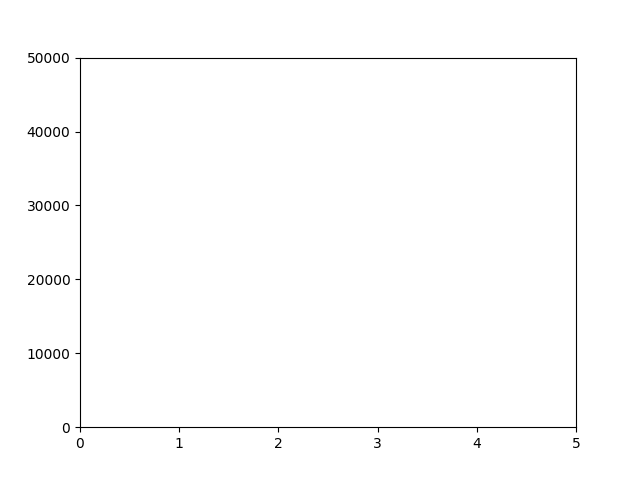

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from heartbeat import acquire
%matplotlib widget

sampling_rate = 200 # samples per second
sampling_duration = 5 # seconds
number_of_samples = sampling_rate * sampling_duration

x = np.arange(number_of_samples)/sampling_rate
y = np.full_like(x, np.nan)

fig, ax = plt.subplots()
line,  = plt.plot(x, y)
plt.xlim(0, sampling_duration)

# setting the lower and upper limits of the y-axis
plt.ylim(0, 50000) # ADJUST THIS HERE until you can identify your heartbeat

plt.show()

Next, run the following cell. Notice that this cell has a `while True` loop in it, which will continue to acquire data until we decide to stop it. Place your finger on the sensor module, and see if you can see movement on the graph above. **Notice here** that the graph will probably look pretty flat, this is because we are zoomed out quite a bit on the y axis. Adjust the second to last line of the code block above until you can notice your heartbeat in the graph. Once the graph of your heart rate looks pretty constant, go ahead and click the stop button at the top of this window (the dark gray square) when the readings reach the right side of the graph.

In [ ]:
try:
    while True:
        acquire(sampling_rate, y, line, fig, number_of_samples)
except KeyboardInterrupt:
    print('done acquiring!')

Exception: No Raspberry Pi Pico was detected. Check to make sure it is plugged in, and that no other programs are accessing it

Re-run the above cell as many times as you need to get a good, clean measurement which shows a clear heartbeat pattern. On me, it looks something like this:

![example heartbeat](https://github.com/TheDataScienceLabs/DSLab_Calculus/blob/main/book/labs/2_determine_heart_rate/data_example.png?raw=true)

**This is important:** Once you have a good measurement, run the following cell to save your measurement to a file.

In [ ]:
np.savetxt('heartbeat.txt', y)

This sensor sometimes has difficulty getting a reading for some people. While we do not know exactly what factors contribute to this, there are plenty of reasons it might not work, including skin quality, natural oil, applied oils, and even skin color might be impacting the results. As such, if you are not able to get a reading after a few tries, use the [example_heartbeat.txt](https://raw.githubusercontent.com/TheDataScienceLabs/DSLab_Calculus/main/book/labs/2_determine_heart_rate/example_heartbeat.txt) file for the rest of the lab.

Have a look at the file you just made - or the example file, if needed (you should be able to open it right here in Jupyterlab). You should see a long list of numbers.

It is a very good practice to use a separate document to store your data. By not storing your data within the document you use to analyze it, you will be able to run your analysis several times without fear of changing your original data. For this reason, we have saved another copy of your results above to a file named 'heartbeat.txt'

## <span style="color:orange;"> 3. Analysis </span>

Here is how to load your data file back into Python:

In [ ]:
y = np.loadtxt("example_heartbeat.txt")

print(y[:20])  # show me just the first 20 entries

[12284. 12282. 12282. 12282. 12284. 12283. 12281. 12280. 12280. 12280.
 12281. 12278. 12279. 12277. 12277. 12277. 12277. 12278. 12277. 12358.]


A good first step for understanding data is to visualize it -- that is, make a plot. Before that, we will call `%matplotlib inline` to change out of interactive plotting mode.

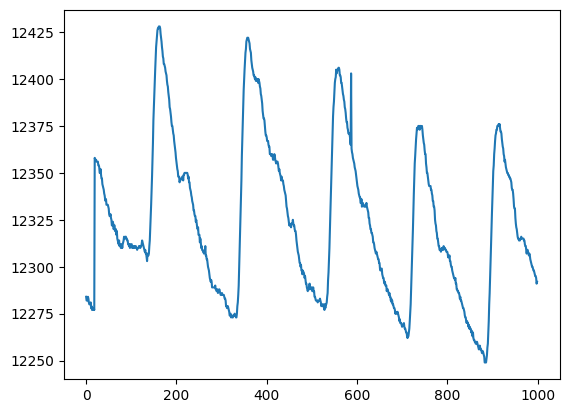

In [ ]:
%matplotlib inline

plt.plot(y)
plt.show()

Unfortunately the x-axis is all wrong -- it is just counting measurements one by one, not giving us the actual time of each measurement. To fix this, we can make an array which has the time each measurement was taken.

### <span style="color:red;"> Exercise 4 </span>

Make an array called `t` which has the time corresponding to each measurement. We need an array that can function as the values for the x-axis. If you feel stuck, look at the previous notebook for inspiration.

<h3 style="background-color:lightblue"> Write Answers for Exercise 4 Below </h3>

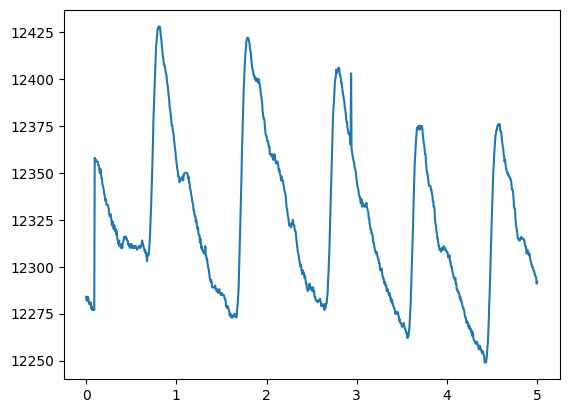

In [ ]:
t = np.array
t= np.linspace(0,5,1000)

plt.plot(t, y)
plt.show()

Now we will zoom in to see just the first second. You can use the command `plt.xlim`. To understand what the command does and the required arguments, we can call  $\mathtt{help()}$, Python's built in help system.

In [ ]:
help(plt.xlim)

Help on function xlim in module matplotlib.pyplot:

xlim(*args, **kwargs)
    Get or set the x limits of the current axes.
    
    Call signatures::
    
        left, right = xlim()  # return the current xlim
        xlim((left, right))   # set the xlim to left, right
        xlim(left, right)     # set the xlim to left, right
    
    If you do not specify args, you can pass *left* or *right* as kwargs,
    i.e.::
    
        xlim(right=3)  # adjust the right leaving left unchanged
        xlim(left=1)  # adjust the left leaving right unchanged
    
    Setting limits turns autoscaling off for the x-axis.
    
    Returns
    -------
    left, right
        A tuple of the new x-axis limits.
    
    Notes
    -----
    Calling this function with no arguments (e.g. ``xlim()``) is the pyplot
    equivalent of calling `~.Axes.get_xlim` on the current axes.
    Calling this function with arguments is the pyplot equivalent of calling
    `~.Axes.set_xlim` on the current axes. All argume

Now we see that to call this function, we just need to give it a left and right endpoint as arguments.

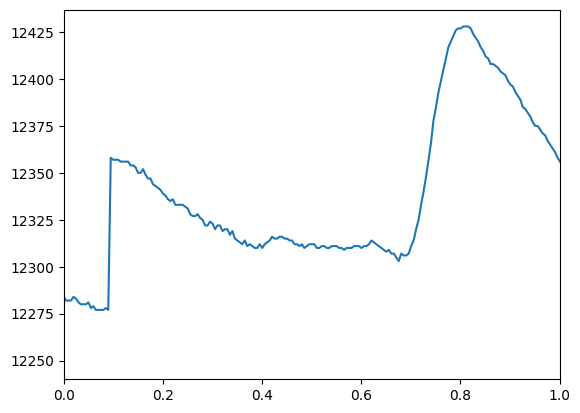

In [ ]:
plt.plot(t, y)
plt.xlim(0, 1)
plt.show()

There is some jaggedness to the signal. This is present because the Pulse Sensor has some noise in its circuitry -- it introduces some random error. We can get rid of it using the same trick we always use to manage random error: averaging. Specifically, we can average each point with its neighbors. The following code averages each point with its ten nearest neighbors on each side, then plots the result.

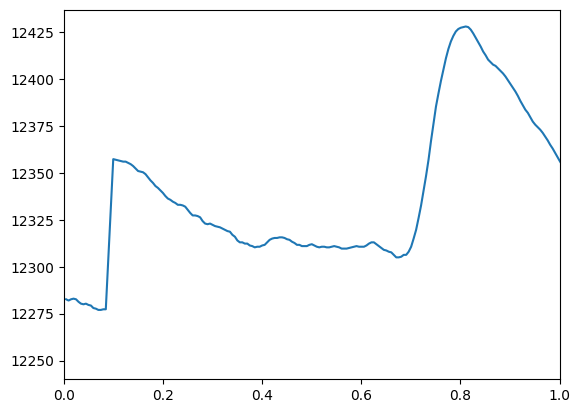

In [ ]:
from heartbeat import rolling_centered_average

averaged = rolling_centered_average(y, 3)
plt.plot(t, averaged)
plt.xlim(0, 1)
plt.show()

Notice that the signal is smoother, but there is still some unwanted jiggle to it. Increase the number of terms in the average until it goes up and down smoothly and only peaks at the highest points.

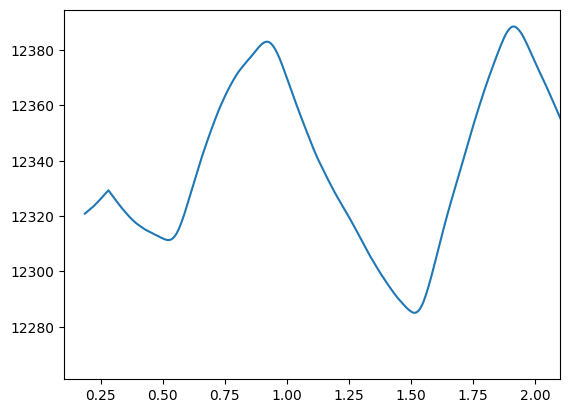

In [ ]:
averaged = rolling_centered_average(y,75)  # You fill in an appropriate number

plt.plot(t, averaged)
plt.xlim(0.1, 2.1)
plt.show()

Our main objective is to identify the frequency of this signal -- that is, the heart rate. To do that, let's see if we can mark the local maxima. Here is an example of a function which will identify those points where the function is increasing (where the current value is bigger than the previous). It may give a warning about invalid values -- that's because we don't have any good average values for the values at the ends, so they are filled in with the "not a number" value, `NaN`.

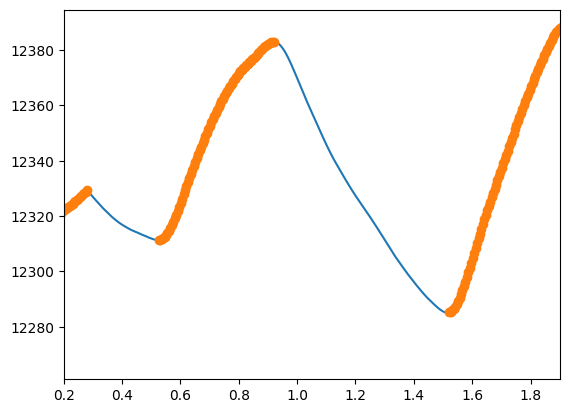

In [ ]:
increasing = np.zeros(
    averaged.shape, dtype=bool
)  # this creates an array filled with False
increasing[1:] = averaged[1:] > averaged[:-1]
plt.plot(t, averaged)
plt.plot(t[increasing], averaged[increasing], "o")
plt.xlim(0.2, 1.9)
plt.show()

We can see where it is decreasing by looking at the complement. Make a plot similar to the above, showing where the function is decreasing.

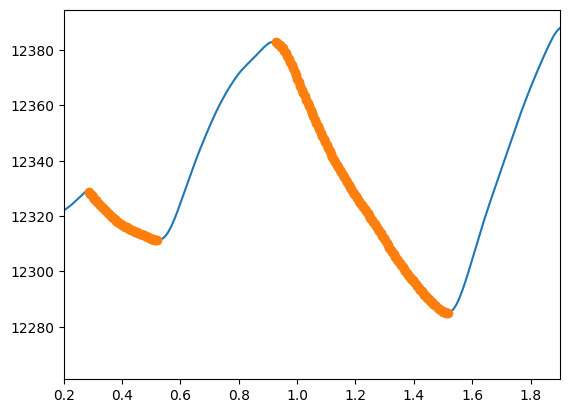

In [ ]:
decreasing = ~increasing

decreasing[:1] = averaged[:1] > averaged[-1:]
plt.plot(t, averaged)
plt.plot(t[decreasing], averaged[decreasing], "o")
plt.xlim(0.2, 1.9)
plt.show()
# You make a plot here, similar to the above (this is not graded, but will help make sure everything is working)


Now it is just a matter of finding where the switch occurs:

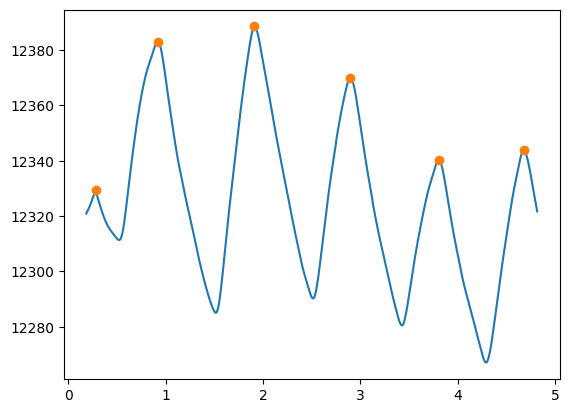

In [ ]:
maxima = np.zeros(averaged.shape, dtype=bool)
maxima[:-1] = increasing[:-1] & decreasing[1:]

plt.plot(t, averaged)
plt.plot(t[maxima], averaged[maxima], "o")
plt.show()

Finally, we can remove any smaller wobbles by using a threshold -- only counting maxima above a certain value. This will get us only those top peaks.

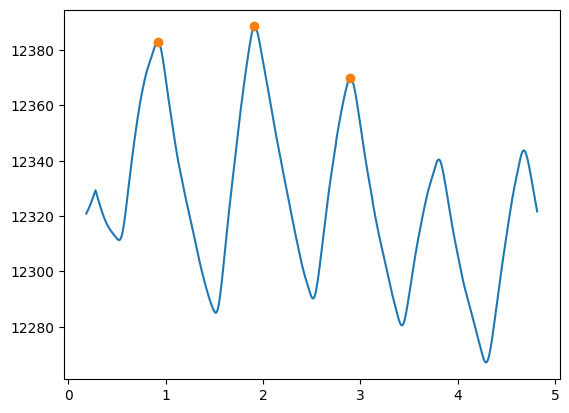

In [ ]:
peak_indices = maxima & (averaged > averaged[maxima].mean())

plt.plot(t, averaged)
plt.plot(t[peak_indices], averaged[peak_indices], "o")
plt.show()

Now that we have identified the peaks, we can take the times these have occurred and compute the BPM.

In [ ]:
peak_times = t[peak_indices]
peak_times

array([0.92092092, 1.91191191, 2.8978979 ])

### <span style="color:red;"> Exercise 5 </span>

Use the peak times to compute your BPM.

<h3 style="background-color:lightblue"> Write Answers for Exercise 5 Below </h3>

In [ ]:
peakIntervals = np.diff(peak_times)
avarageIntervals = np.mean(peakIntervals)

bpm= 60/avarageIntervals

print(f"The avarage bpm is {bpm:.2f}")

The avarage bpm is 60.70


### That's all for today!

Well done! Today we learned a bit about the terminology of error analysis, we learned how to interface with a microcontroller using Python, and we developed a procedure for computing the BPM from a photoplethysmogram sensor. In next week's lab, we will learn how to make that process automatic, and do a more sophisticated analysis of the data you collected today.

Make sure you save the code you wrote today, because you will need it next week (you can hit the save button at the top of the notebook). Then, make sure to submit your notebook you used today to Gradescope.